In [1]:
import awkward as ak
import h5py
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import os
import yaml
from helpers import load_dataset, stack

mplhep.style.use("CMS")

Als nächstes laden wir die Daten. Dies kann einige Minuten dauern, da **mehrere Millionen** Events eingelesen werden müssen.

In [2]:
datasets = {}
for n, file in enumerate(os.listdir("skimmed_datasets")):
    print(f"Working on {file} ({n + 1}/8)")
    h5file = h5py.File(os.path.join("skimmed_datasets", file), "r")
    datasets.update({file[:-3]: load_dataset(h5file)})
print("Finished!")

Working on ZZTo4e.h5 (1/8)
Working on ZZTo4mu.h5 (2/8)
Working on Run2012B_DoubleMuParked.h5 (3/8)
Working on SMHiggsToZZTo4L.h5 (4/8)
Working on Run2012C_DoubleMuParked.h5 (5/8)
Working on Run2012B_DoubleElectron.h5 (6/8)
Working on Run2012C_DoubleElectron.h5 (7/8)
Working on ZZTo2e2mu.h5 (8/8)
Finished!


Alle events sind nun nach Datensatz geordnet in `datasets` gespeichert. Nun ist es an der Zeit alle für uns irrelevanten Events herauszufiltern. 

In [100]:
def filter_dataset(ds: dict):
    muons = ds["muons"]
    electrons = ds["electrons"]

    ### Myonen
    passes_pt = muons["pt"] > 5
    passes_eta = abs(muons["eta"]) < 2.4
    muons = muons[passes_pt & passes_eta]

    ### Elektronen
    passes_pt = electrons["pt"] > 7
    passes_eta = abs(electrons["eta"]) < 2.5
    electrons = electrons[passes_pt & passes_eta]

    ### Event
    ### Genau 4 Leptonen
    leptons = ak.concatenate((muons, electrons), axis = 1)
    has_4mu = (ak.num(muons) == 4) & (ak.num(electrons) == 0)
    has_4e = (ak.num(muons) == 0) & (ak.num(electrons) == 4)
    has_2mu2e = (ak.num(muons) == 2) & (ak.num(electrons) == 2)
    leptons = leptons[has_4mu | has_4e | has_2mu2e]
    muons = muons[has_4mu | has_4e | has_2mu2e]
    electrons = electrons[has_4mu | has_4e | has_2mu2e]
    
    ### Gesamtladung null
    has_0Q_mu = ak.sum(muons["charge"], axis = 1) == 0
    has_0Q_e = ak.sum(electrons["charge"], axis = 1) == 0
    leptons = leptons[has_0Q_mu & has_0Q_e]
    muons = muons[has_0Q_mu & has_0Q_e]
    electrons = electrons[has_0Q_mu & has_0Q_e]

    ### 2e2mu
    muon_pt_sorted = ak.sort(muons["pt"], ascending = False)
    muon_pt_sorted = ak.fill_none(ak.pad_none(muon_pt_sorted, 2), -1)
    muon_mask = (muon_pt_sorted[:, 0] > 20) & (muon_pt_sorted[:, 1] > 10)
    electron_pt_sorted = ak.sort(electrons["pt"], ascending = False)
    electron_pt_sorted = ak.fill_none(ak.pad_none(electron_pt_sorted, 2), -1)
    electron_mask = (electron_pt_sorted[:, 0] > 20) & (electron_pt_sorted[:, 1] > 10)
    pt_mask_2e2mu = ak.where(ak.num(muons) == 2, muon_mask & electron_mask, ak.num(muons) != 2)
    electrons = electrons[pt_mask_2e2mu]
    muons = muons[pt_mask_2e2mu]
    leptons = leptons[pt_mask_2e2mu]

    ### Massenberechnung
    mZ = 91
    pos = leptons[leptons["charge"] > 0]
    neg = leptons[leptons["charge"] < 0]
    c1 = ak.concatenate(
        (
            ak.unflatten((pos[:, 0].to_xyzt() + neg[:, 0].to_xyzt()).mass, 1),
            ak.unflatten((pos[:, 1].to_xyzt() + neg[:, 1].to_xyzt()).mass, 1)
        ), axis = 1
    )
    c2 = ak.concatenate(
        (
            ak.unflatten((pos[:, 0].to_xyzt() + neg[:, 1].to_xyzt()).mass, 1),
            ak.unflatten((pos[:, 1].to_xyzt() + neg[:, 0].to_xyzt()).mass, 1)
        ), axis = 1
    )
    c = ak.unflatten(
        ak.concatenate((c1, c2), axis = 1), 2, axis = -1
    )
    x = ak.min(abs(c - mZ), axis = -1)
    y = ak.argmin(x, axis = -1, keepdims = True)
    Z = c[y][:, 0]
    s = ak.argsort(abs(Z - mZ), axis = 1)
    Z = Z[s]

    ### Z1 = [40, 120], Z2 = [12, 120]
    maskZ1 = (Z[:, 0] > 40) & (Z[:, 0] < 120)
    maskZ2 = (Z[:, 1] > 12) & (Z[:, 1] < 120)
    mask_4l = maskZ1 & maskZ2

    ### For 2e2mu
    Zee = ak.sum(electrons.to_xyzt(), axis = 1).mass
    Zmumu = ak.sum(muons.to_xyzt(), axis = 1).mass
    Z = stack(Zee, Zmumu)
    s = ak.argsort(abs(Z - mZ), axis = 1)
    Z = Z[s]
    maskZ1 = (Z[:, 0] > 40) & (Z[:, 0] < 120)
    maskZ2 = (Z[:, 1] > 12) & (Z[:, 1] < 120)
    mask_2e2mu = maskZ1 & maskZ2

    mask_4l = ak.where(ak.num(muons) != 2, mask_4l, ak.num(muons) == 2)
    mask_2e2mu = ak.where(ak.num(muons) == 2, mask_2e2mu, ak.num(muons) != 2)
    
    leptons = leptons[mask_4l & mask_2e2mu]
    
    m4l = ak.sum(leptons.to_xyzt(), axis = 1).mass

    return m4l.to_numpy()

In [101]:
m4l = {}
for name, ds in datasets.items():
    print(f"Working on {name}")
    m4l.update({name: filter_dataset(ds)})
print("Finished!")

Working on ZZTo4e
[[58.1, 6.92], [64.5, 14.6], [91.5, 130], ..., [...], [90.2, 61.1], [92, 95.7]]
[[90.5, 0], [97.3, 0], [0, 295], [179, ...], ..., [0, 187], [166, 0], [0, 261]]
Working on ZZTo4mu
[[93.4, 101], [91.7, 94.7], [65.1, 4.16], ..., [66.8, 4.14], [92.9, 7.82]]
[[0, 324], [0, 378], [91.5, 0], [...], ..., [99.4, 0], [92.8, 0], [165, 0]]
Working on Run2012B_DoubleMuParked
[[61.2, 9.4], [89.2, 20.1], [91.8, 90], ..., [...], [92, 93.4], [26.2, 23.3]]
[[86.6, 0], [140, 0], [91.8, 90], [...], ..., [89.4, 0], [0, 548], [53.7, 0]]
Working on SMHiggsToZZTo4L
[[76.8, 39.1], [90.5, 11.6], [59.7, 56], ..., [...], [75.9, 42.4], [89.3, 32.6]]
[[123, 0], [90.5, 11.6], [118, 0], ..., [117, ...], [75.9, 42.4], [89.3, 32.6]]
Working on Run2012C_DoubleMuParked
[[59.8, 9.2], [82.1, 0.763], [93.6, 82.1], ..., [90.9, 90.3], [67.8, 1.02]]
[[59.8, 9.2], [88.2, 0], [0, 317], [...], ..., [91.5, 0], [0, 190], [89.8, 0]]
Working on Run2012B_DoubleElectron
[[91.5, 89.1], [52.9, 13.5], [79.2, ...], ..., [

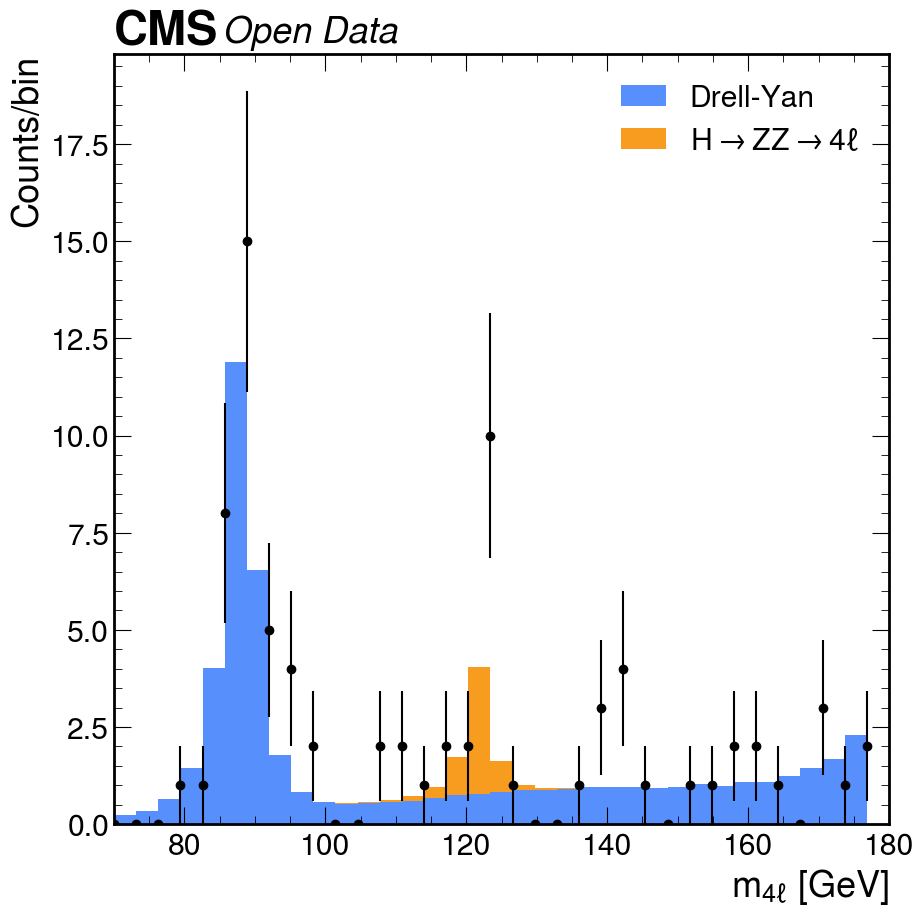

In [102]:
with open("weights.yaml", "r") as wfile: weights = yaml.safe_load(wfile)

### Erstelle Histogramme
bins = np.linspace(70, 180, 36)
hists = {
    name: np.histogram(m4l[name], bins)[0] * weights[name] for name in m4l.keys()
}

data = (
    hists["Run2012B_DoubleMuParked"] + hists["Run2012C_DoubleMuParked"]
    + hists["Run2012B_DoubleElectron"] + hists["Run2012C_DoubleElectron"]
)
stat = np.sqrt(data)

mplhep.cms.text("Open Data")
plt.stackplot(
    bins[:-1],
    hists["ZZTo4mu"] + hists["ZZTo4e"] + hists["ZZTo2e2mu"],
    hists["SMHiggsToZZTo4L"],
    labels = ["Drell-Yan", "$H \\rightarrow ZZ \\rightarrow 4\\ell$"],
    step = "pre"
)
plt.errorbar(
    bins[:-1], data, yerr = stat, fmt = "o", color = "black"
)
plt.xlabel("$m_{4\\ell}$ [GeV]")
plt.ylabel("Counts/bin")
plt.xlim(70, 180)
plt.legend()
plt.show()